# Conformal inference: regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

from mapie.metrics import regression_coverage_score
from mapie.regression import MapieQuantileRegressor, MapieRegressor

from utils import plot_1d_data, x_sinx, get_1d_data_with_constant_noise

## Estimating the aleatoric uncertainty

Simulate data with DGP: homoscedastic 1D non-linear process f(x)

In [2]:
n_samples = 10**3
min_x, max_x, noise = -5, 5, 0.5

X_train, y_train, X_test, y_test, y_mesh = get_1d_data_with_constant_noise(x_sinx, min_x, max_x, n_samples, noise)

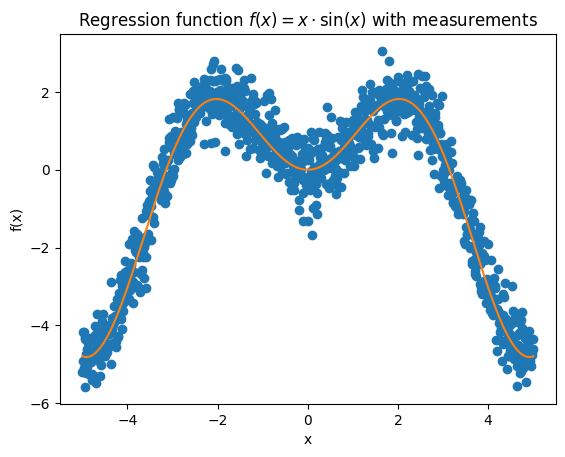

In [3]:
plt.scatter(X_train, y_train, color="C0")             # measurements
_ = plt.plot(X_test, y_mesh, color="C1")              # latent regression function
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title(r'Regression function $f(x) = x\cdot \sin(x)$ with measurements')
plt.show()

In [13]:
polyn_model = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=10)),
        ("model", RandomForestRegressor(n_estimators=50, random_state=42))
        # ("linear", QuantileRegressor(
        #         solver="highs",
        #         alpha=0,
        # ))
    ]
)

mapie = MapieRegressor(polyn_model, verbose=1)

mapie.fit(X_train, y_train)

y_pred, y_set = mapie.predict(X_test, alpha=0.05)

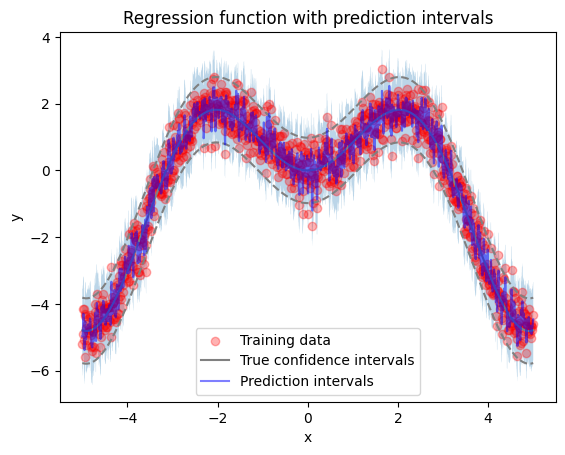

In [16]:
plot_1d_data(
    X_train.ravel(),
    y_train.ravel(),
    X_test.ravel(),
    y_mesh.ravel(),
    np.full((X_test.shape[0]), 1.96*noise).ravel(),     # true predictive interval
    y_pred.ravel(),
    y_set[:, 0, 0].ravel(),
    y_set[:, 1, 0].ravel(),
    title=r'Regression function with prediction intervals'
)

## Example: California Housing dataset

View response variable

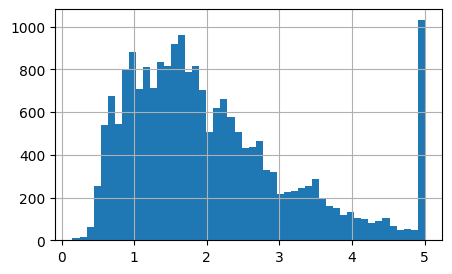

In [5]:
# Fetching the California Housing dataset
housing = fetch_california_housing()

X, y = housing.data, housing.target
X.shape, y.shape

pd.Series(y).hist(bins=50, figsize=(5, 3));

Partition data:

In [6]:
X_train, X_rest1, y_train, y_rest1 = train_test_split(X, y, train_size=0.8, random_state=42)
X_test, X_rest2, y_test, y_rest2 = train_test_split(X_rest1, y_rest1, train_size=0.8, random_state=42)
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, train_size=0.8, random_state=42)


In [7]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_calib = scaler.transform(X_calib)
X_new = scaler.transform(X_new)

print(X_train.shape)
print(X_test.shape)
print(X_calib.shape)
print(X_new.shape)

(16512, 8)
(3302, 8)
(660, 8)
(166, 8)


In [8]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

MAE: 0.32756101293155676


In [9]:
from mapie.regression import MapieRegressor

mapie_reg = MapieRegressor(estimator=model, cv='prefit', n_jobs=-1, verbose=1)

mapie_reg.fit(X_calib, y_calib)

MapieRegressor(cv='prefit', estimator=RandomForestRegressor(random_state=42),
               method='base', n_jobs=-1, verbose=1)

In [16]:
alpha = 0.05
y_pred, y_set = mapie_reg.predict(X_new, alpha=alpha)

In [17]:
i = 0             # first sample
interval = y_set[i].flatten()    

print(f"{(1-alpha)*100:.0f}% predictive interval: [{interval[0]:.2f}, {interval[1]:.2f}]")

95% predictive interval: [2.71, 4.93]


In [18]:
from mapie.metrics import regression_coverage_score_v2, regression_mean_width_score

coverage = regression_coverage_score_v2(y_new, y_set)

print(f"Coverage: {coverage[0]:.2f}")

Coverage: 0.94


In [19]:
size = regression_mean_width_score(y_set[0], y_set[1])

print(f"Avg. interval width: {size:.2f}")

Avg. interval width: 0.55
